In [269]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import catboost
pd.options.display.max_rows = None
pd.options.display.max_columns = None
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
# Load data
# Loading data
train = pd.read_csv('./train.csv')
test = pd.read_csv('./test.csv')
train.drop(["Id"],inplace=True,axis=1)
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestRegressor
from catboost import CatBoostRegressor
from sklearn.tree import plot_tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectFromModel


## Which numeric features have missing values? 

In [261]:
numeric_features = train.select_dtypes(exclude=["object"])
# Get a Boolean DataFrame indicating missing values
missing_values = numeric_features.isna().any()

# Get the columns that have missing values

# Get the count of missing values per column
missing_values_count = numeric_features.isna().sum()

# Get the columns that have missing values and sort by number of missing values
columns_with_missing_values = missing_values_count[missing_values].sort_values().index.tolist()


for column in columns_with_missing_values:
    count = missing_values_count[column]
    print(f'"{column}" has {count} missing value(s).')

"MasVnrArea" has 8 missing value(s).
"GarageYrBlt" has 81 missing value(s).
"LotFrontage" has 259 missing value(s).


### We will define GarageYrBlt = NaN as 0, since the house dosen't have garage
### Same for LotFrontage and MasVnrArea as NaN means no linear feet of street connected to property


In [262]:
train.GarageYrBlt.fillna(0,inplace=True)
train.LotFrontage.fillna(0,inplace=True)
train.MasVnrArea.fillna(0,inplace=True)
numeric_features = train.drop(["SalePrice"],axis=1).select_dtypes(exclude=["object"])

## Cleaning missing values in categorical features

In [263]:
categorical_features = train.select_dtypes(include=["object"])
# Get a Boolean DataFrame indicating missing values
missing_values = categorical_features.isna().any()

# Get the columns that have missing values

# Get the count of missing values per column
missing_values_count = categorical_features.isna().sum()

# Get the columns that have missing values and sort by number of missing values
columns_with_missing_values = missing_values_count[missing_values].sort_values().index.tolist()


for column in columns_with_missing_values:
    count = missing_values_count[column]
    print(f'"{column}" has {count} missing value(s).')


"Electrical" has 1 missing value(s).
"MasVnrType" has 8 missing value(s).
"BsmtQual" has 37 missing value(s).
"BsmtCond" has 37 missing value(s).
"BsmtFinType1" has 37 missing value(s).
"BsmtExposure" has 38 missing value(s).
"BsmtFinType2" has 38 missing value(s).
"GarageType" has 81 missing value(s).
"GarageFinish" has 81 missing value(s).
"GarageQual" has 81 missing value(s).
"GarageCond" has 81 missing value(s).
"FireplaceQu" has 690 missing value(s).
"Fence" has 1179 missing value(s).
"Alley" has 1369 missing value(s).
"MiscFeature" has 1406 missing value(s).
"PoolQC" has 1453 missing value(s).


### Electrical:  Missing was set to the mode of neighborhood its neighborhood

#### The remainings features  contain NaN values because they represent a qualitative measurement of a property that doesn't exist. For instance, if a row has a value of 0 for 'Fireplaces', then 'FireplaceQu' will also be NaN. To make it easier to work with the data later, I've converted all these NaN values to the string "Na".

In [264]:
# Electricity
most_common_in_neigh = categorical_features[(categorical_features['Neighborhood'] == categorical_features.loc[1379]['Neighborhood'])]["Electrical"].value_counts().index[0]
categorical_features.loc[1379, 'Electrical']  = most_common_in_neigh


## Remaining


# Get a Boolean DataFrame indicating missing values
missing_values = categorical_features.isna().any()

# Get the columns that have missing values

# Get the count of missing values per column
missing_values_count = categorical_features.isna().sum()

# Get the columns that have missing values and sort by number of missing values
columns_with_missing_values = missing_values_count[missing_values].sort_values().index.tolist()


for col in columns_with_missing_values: # columns related to garage and basement
    
    categorical_features[col].fillna("Na", inplace=True)


## Splitting data into categorical, continuous and ordinal.

In [265]:
continuous_features = numeric_features[ ['MiscVal',"LotFrontage", 'LotArea', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2','BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF',
                                         'LowQualFinSF','GrLivArea','GarageArea', 'WoodDeckSF','OpenPorchSF','3SsnPorch','EnclosedPorch', 'ScreenPorch', 'PoolArea'] ].copy()

discrete_features = numeric_features[list(set(numeric_features.columns) - set(continuous_features.columns))].copy()

categorical_features["MSSubClass"] = discrete_features.MSSubClass
discrete_features.drop("MSSubClass",axis=1,inplace=True)

categorical_features["MoSold"] = discrete_features.MoSold
discrete_features.drop("MoSold",axis=1,inplace=True)

#### Idea #1 : decide which features in categorical are ordinary in nature, and which aren't. The ideea is to assaign values to ordinary features (like 'OverallCond') and one-hot-enconding to true categorical features.

#### Idea  #2 : remove features where one category has much more counts than the others, making this feature informationless.

#### A drawback to this is that we perhaps loss information about edge cases: this is fine however, as first i am trying to make a simple generic model.



## <ins> Idea 1

### After inspection, the next features were chosen as ordinal features:

##### 'ExterCond','ExterQual', 'BsmtQual','BsmtCond','BsmtExposure','BsmtFinType1','BsmtFinType2',
##### 'HeatingQC','KitchenQual','Functional','FireplaceQu','GarageFinish','GarageQual'


### <ins> Remark: Many of this features has Na in it, which is not strictly ordinal

### We will check if having basement in general is better than having no basement, and if os. we can rank Na as lowest. same for garage

### The general trend is that indeed no garage or basment lowers the price of the house, so we will assign the lowest value to Na 

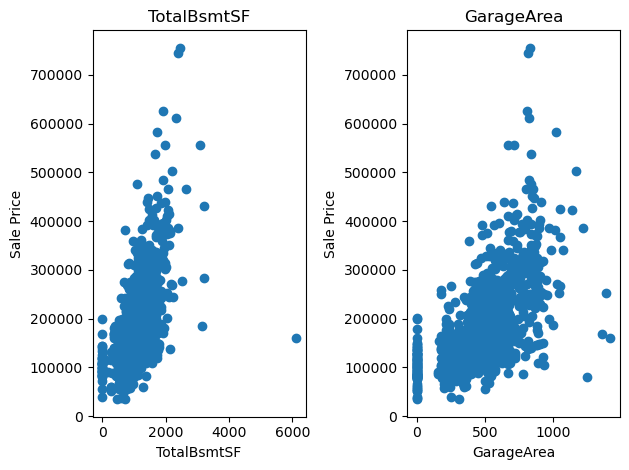

In [266]:
columns = ['TotalBsmtSF','GarageArea']

for i,col in enumerate(columns):
    plt.subplot(1,2,i+1)
    x = numeric_features[col]
    y = train.SalePrice.values
    plt.scatter(x,y)
    # Add a title and labels to the x and y axes
    plt.title("{}".format(col))
    plt.xlabel(col)
    plt.ylabel("Sale Price")

# Show the plot

plt.tight_layout()

## Splitting categorical features to ordinal and categorical

In [267]:
columns = ['ExterCond','ExterQual', 'BsmtQual','BsmtCond','BsmtExposure','BsmtFinType1','BsmtFinType2','HeatingQC','KitchenQual','Functional','FireplaceQu','GarageFinish','GarageQual']
ordinal_features = categorical_features[columns].copy()

categorical_features.drop(columns,axis=1,inplace=True)

mapping = {'Ex': 5, 'Gd': 4, 'TA': 3, 'Fa': 2, 'Po': 1, 'Na': 0,
    'Gd': 4, 'Av': 3, 'Mn': 2, 'No': 1,
    'GLQ': 6, 'ALQ': 5, 'BLQ': 4, 'Rec': 3, 'LwQ': 2, 'Unf': 1,
    'Typ': 7, 'Min1': 6, 'Min2': 5, 'Mod': 4, 'Maj1': 3, 'Maj2': 2, 'Sev': 1, 'Sal': 0,
    'Fin': 3, 'RFn': 2, 'Unf': 1}


for col in columns:
    ordinal_features[col] = ordinal_features[col].map(mapping)


#### Lastly we need to convert features with int dtype to string and to one-hot-encode the categorical data:

In [268]:
int_cols = categorical_features.select_dtypes(include='int').columns
# Change datatype of all integer columns to string
categorical_features[int_cols] = categorical_features[int_cols].astype(str)

# get dummies
categorical_features = pd.get_dummies(categorical_features)

,MSZoning_C (all),MSZoning_FV,MSZoning_RH,MSZoning_RL,MSZoning_RM,Street_Grvl,Street_Pave,Alley_Grvl,Alley_Na,Alley_Pave,LotShape_IR1,LotShape_IR2,LotShape_IR3,LotShape_Reg,LandContour_Bnk,LandContour_HLS,LandContour_Low,LandContour_Lvl,Utilities_AllPub,Utilities_NoSeWa,LotConfig_Corner,LotConfig_CulDSac,LotConfig_FR2,LotConfig_FR3,LotConfig_Inside,LandSlope_Gtl,LandSlope_Mod,LandSlope_Sev,Neighborhood_Blmngtn,Neighborhood_Blueste,Neighborhood_BrDale,Neighborhood_BrkSide,Neighborhood_ClearCr,Neighborhood_CollgCr,Neighborhood_Crawfor,Neighborhood_Edwards,Neighborhood_Gilbert,Neighborhood_IDOTRR,Neighborhood_MeadowV,Neighborhood_Mitchel,Neighborhood_NAmes,Neighborhood_NPkVill,Neighborhood_NWAmes,Neighborhood_NoRidge,Neighborhood_NridgHt,Neighborhood_OldTown,Neighborhood_SWISU,Neighborhood_Sawyer,Neighborhood_SawyerW,Neighborhood_Somerst,Neighborhood_StoneBr,Neighborhood_Timber,Neighborhood_Veenker,Condition1_Artery,Condition1_Feedr,Condition1_Norm,Condition1_PosA,Condition1_PosN,Condition1_RRAe,Condition1_RRAn,Condition1_RRNe,Condition1_RRNn,Condition2_Artery,Condition2_Feedr,Condition2_Norm,Condition2_PosA,Condition2_PosN,Condition2_RRAe,Condition2_RRAn,Condition2_RRNn,BldgType_1Fam,BldgType_2fmCon,BldgType_Duplex,BldgType_Twnhs,BldgType_TwnhsE,HouseStyle_1.5Fin,HouseStyle_1.5Unf,HouseStyle_1Story,HouseStyle_2.5Fin,HouseStyle_2.5Unf,HouseStyle_2Story,HouseStyle_SFoyer,HouseStyle_SLvl,RoofStyle_Flat,RoofStyle_Gable,RoofStyle_Gambrel,RoofStyle_Hip,RoofStyle_Mansard,RoofStyle_Shed,RoofMatl_ClyTile,RoofMatl_CompShg,RoofMatl_Membran,RoofMatl_Metal,RoofMatl_Roll,RoofMatl_Tar&Grv,RoofMatl_WdShake,RoofMatl_WdShngl,Exterior1st_AsbShng,Exterior1st_AsphShn,Exterior1st_BrkComm,Exterior1st_BrkFace,Exterior1st_CBlock,Exterior1st_CemntBd,Exterior1st_HdBoard,Exterior1st_ImStucc,Exterior1st_MetalSd,Exterior1st_Plywood,Exterior1st_Stone,Exterior1st_Stucco,Exterior1st_VinylSd,Exterior1st_Wd Sdng,Exterior1st_WdShing,Exterior2nd_AsbShng,Exterior2nd_AsphShn,Exterior2nd_Brk Cmn,Exterior2nd_BrkFace,Exterior2nd_CBlock,Exterior2nd_CmentBd,Exterior2nd_HdBoard,Exterior2nd_ImStucc,Exterior2nd_MetalSd,Exterior2nd_Other,Exterior2nd_Plywood,Exterior2nd_Stone,Exterior2nd_Stucco,Exterior2nd_VinylSd,Exterior2nd_Wd Sdng,Exterior2nd_Wd Shng,MasVnrType_BrkCmn,MasVnrType_BrkFace,MasVnrType_Na,MasVnrType_None,MasVnrType_Stone,Foundation_BrkTil,Foundation_CBlock,Foundation_PConc,Foundation_Slab,Foundation_Stone,Foundation_Wood,Heating_Floor,Heating_GasA,Heating_GasW,Heating_Grav,Heating_OthW,Heating_Wall,CentralAir_N,CentralAir_Y,Electrical_FuseA,Electrical_FuseF,Electrical_FuseP,Electrical_Mix,Electrical_SBrkr,GarageType_2Types,GarageType_Attchd,GarageType_Basment,GarageType_BuiltIn,GarageType_CarPort,GarageType_Detchd,GarageType_Na,GarageCond_Ex,GarageCond_Fa,GarageCond_Gd,GarageCond_Na,GarageCond_Po,GarageCond_TA,PavedDrive_N,PavedDrive_P,PavedDrive_Y,PoolQC_Ex,PoolQC_Fa,PoolQC_Gd,PoolQC_Na,Fence_GdPrv,Fence_GdWo,Fence_MnPrv,Fence_MnWw,Fence_Na,MiscFeature_Gar2,MiscFeature_Na,MiscFeature_Othr,MiscFeature_Shed,MiscFeature_TenC,SaleType_COD,SaleType_CWD,SaleType_Con,SaleType_ConLD,SaleType_ConLI,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_Abnorml,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial,MSSubClass_120,MSSubClass_160,MSSubClass_180,MSSubClass_190,MSSubClass_20,MSSubClass_30,MSSubClass_40,MSSubClass_45,MSSubClass_50,MSSubClass_60,MSSubClass_70,MSSubClass_75,MSSubClass_80,MSSubClass_85,MSSubClass_90,MoSold_1,MoSold_10,MoSold_11,MoSold_12,MoSold_2,MoSold_3,MoSold_4,MoSold_5,MoSold_6,MoSold_7,MoSold_8,MoSold_9
1,0,0,0,1,0,0,1,0,1,0,0,0,0,1,0,0,0,1,1,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,1,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0

## <ins>So far:
#### We have split the data into 4:
1. Continuous data
2. Discrete numerical
3. Oridnal
4. Categorical

#### We will now try to find out which features are important using random forest:

In [272]:

# Split the data into features and target
X = categorical_features
y = train.SalePrice

# Train a Random Forest Classifier
clf = RandomForestClassifier(n_estimators=500)
clf.fit(X, y)

# Create a SelectFromModel object to select the most important features
model = SelectFromModel(clf, prefit=True)

# Transform the data to select only the most important features
X_important = model.transform(X)

# Get the names of the selected columns
selected_cols = X.columns[model.get_support()]


c:\Users\yosefos\anaconda3\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


In [271]:
selected_cols

Index(['MSZoning_RL', 'MSZoning_RM', 'Alley_Na', 'LotShape_IR1',
       'LotShape_IR2', 'LotShape_Reg', 'LandContour_Lvl', 'LotConfig_Corner',
       'LotConfig_CulDSac', 'LotConfig_FR2', 'LotConfig_Inside',
       'Neighborhood_CollgCr', 'Neighborhood_Edwards', 'Neighborhood_Gilbert',
       'Neighborhood_Mitchel', 'Neighborhood_NAmes', 'Neighborhood_NWAmes',
       'Neighborhood_NoRidge', 'Neighborhood_NridgHt', 'Neighborhood_OldTown',
       'Neighborhood_Sawyer', 'Neighborhood_SawyerW', 'Neighborhood_Somerst',
       'Neighborhood_Timber', 'Condition1_Feedr', 'Condition1_Norm',
       'BldgType_1Fam', 'BldgType_TwnhsE', 'HouseStyle_1.5Fin',
       'HouseStyle_1Story', 'HouseStyle_2Story', 'RoofStyle_Gable',
       'RoofStyle_Hip', 'Exterior1st_HdBoard', 'Exterior1st_MetalSd',
       'Exterior1st_Plywood', 'Exterior1st_VinylSd', 'Exterior1st_Wd Sdng',
       'Exterior2nd_HdBoard', 'Exterior2nd_MetalSd', 'Exterior2nd_Plywood',
       'Exterior2nd_VinylSd', 'Exterior2nd_Wd Sdng', 'Mas

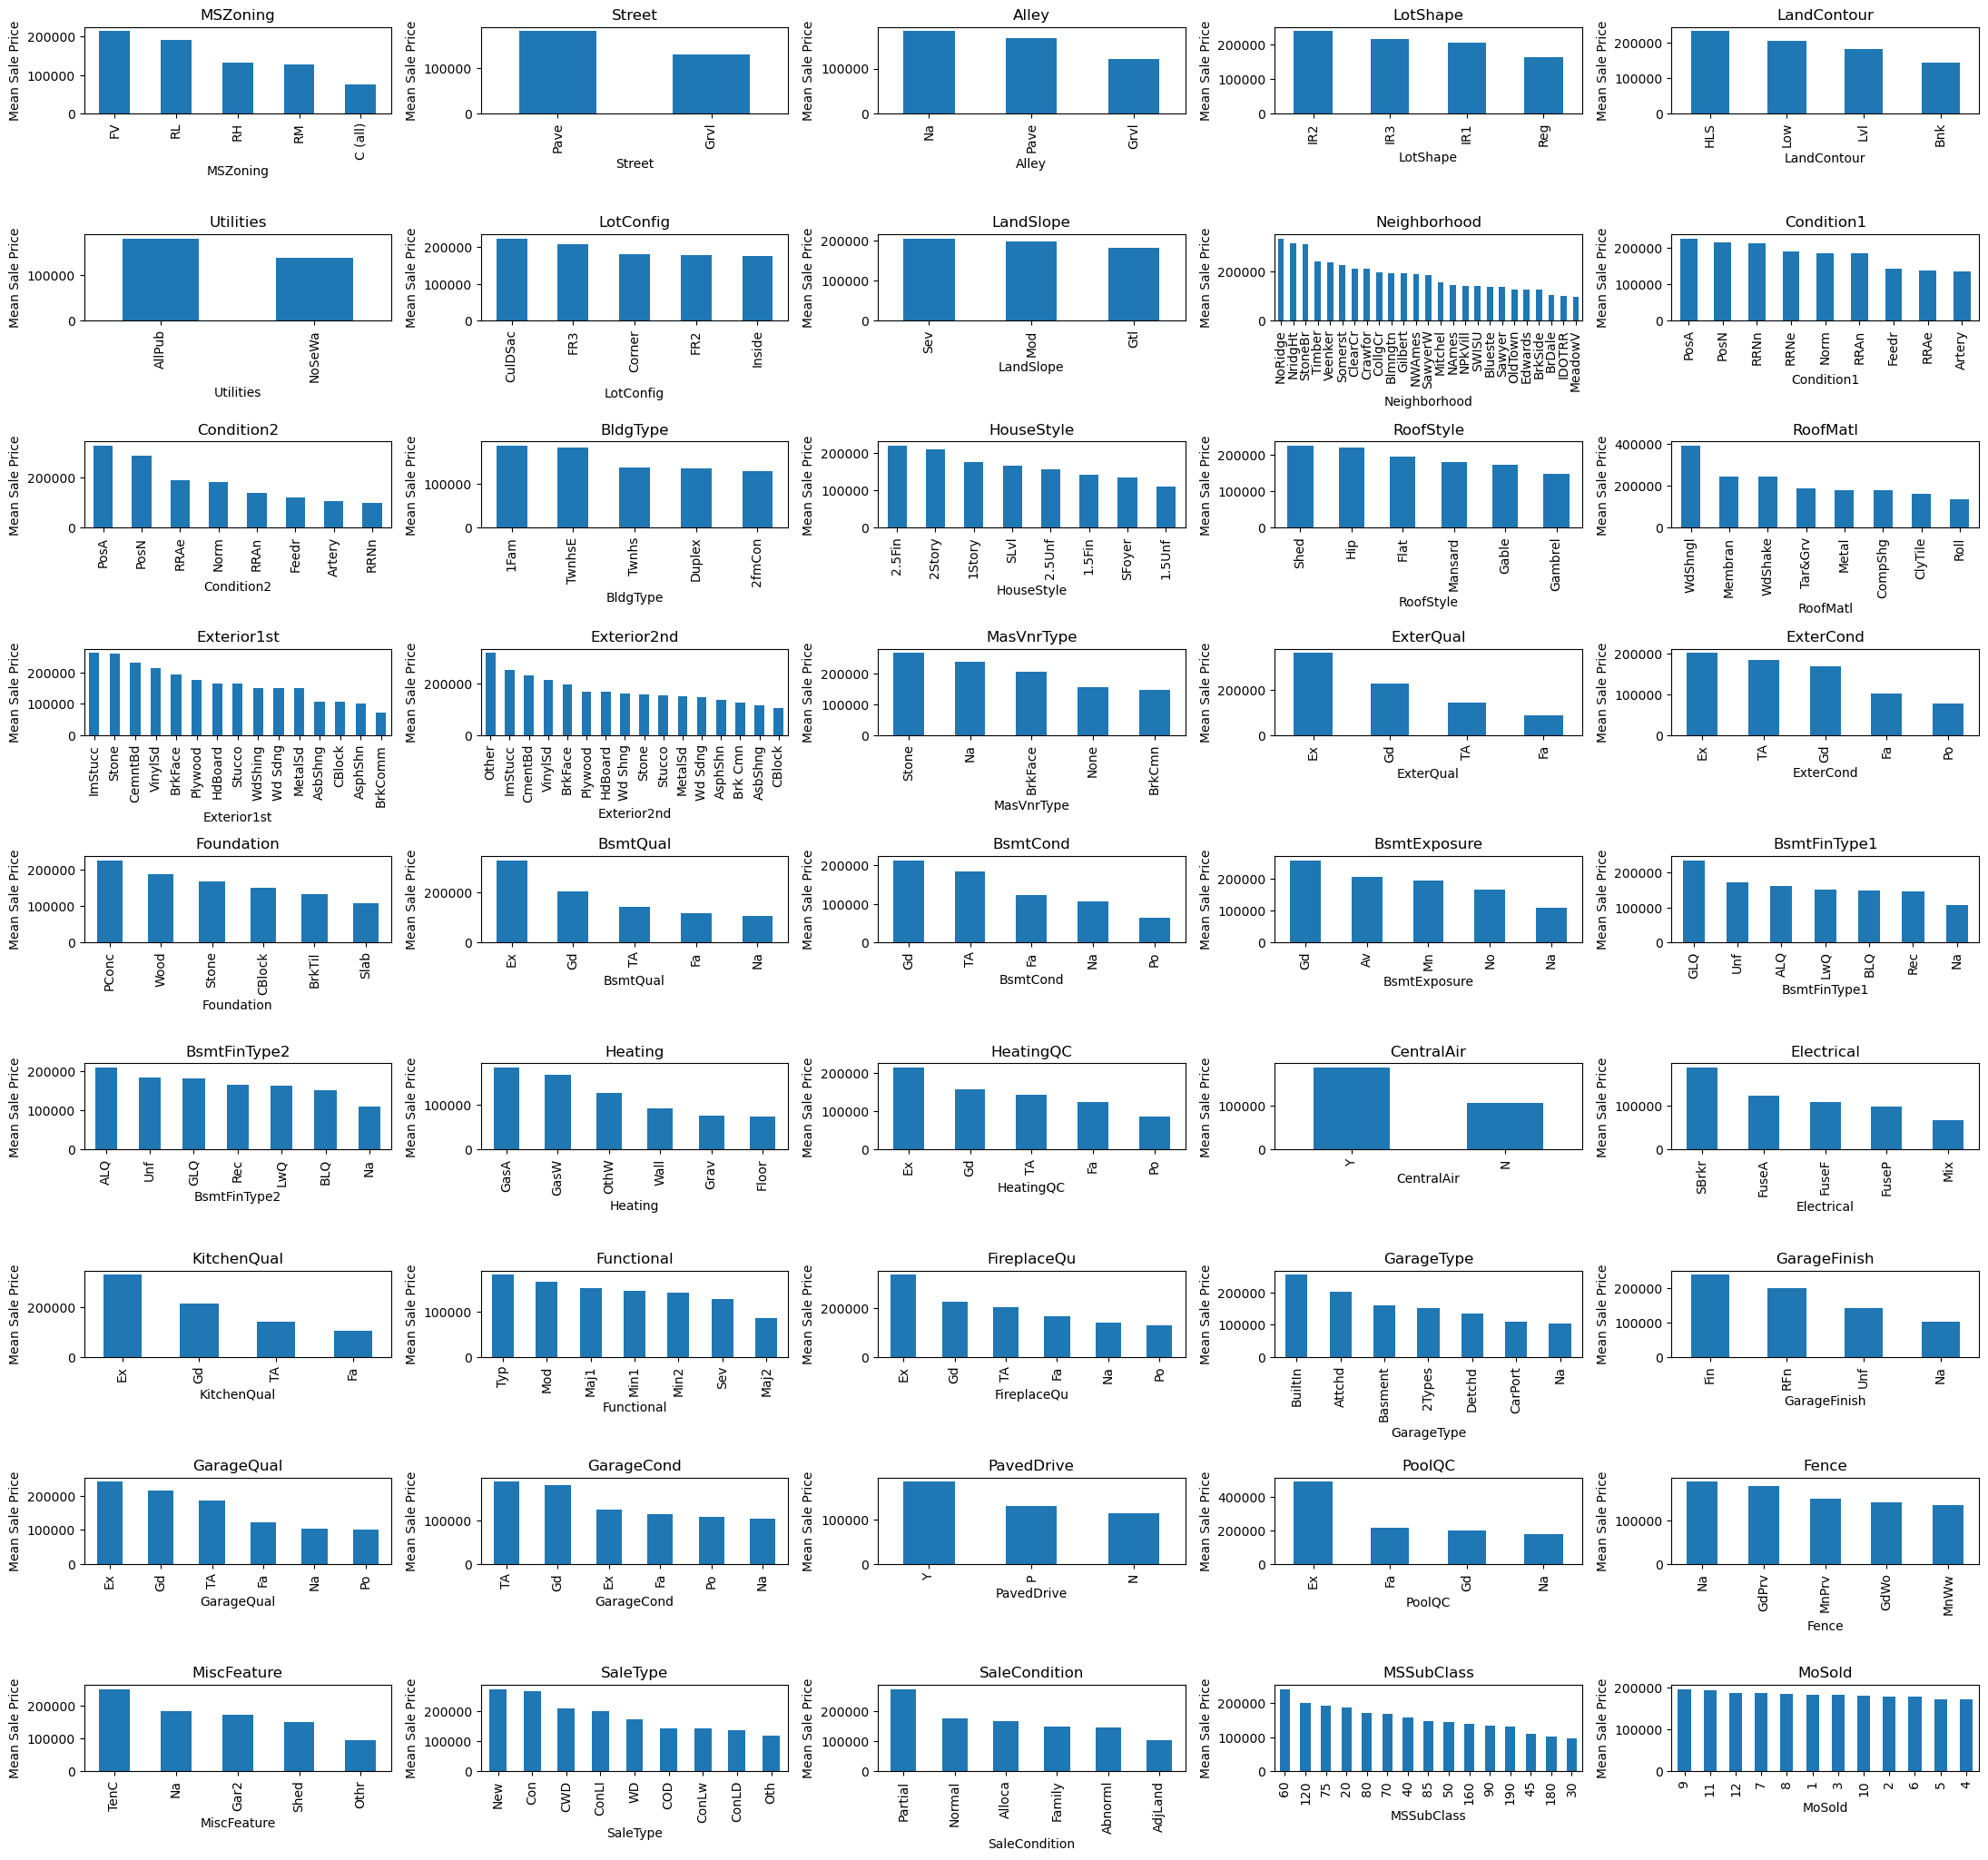

In [91]:
categorical_features["SalePrice"] = train["SalePrice"]
# Group the data by the "MSZoning" column and calculate the mean "SalePrice" value for each group
plt.figure(figsize = (22,22))
for i,col in enumerate(categorical_features.columns):
    if col != 'SalePrice':
        plt.subplot(10,5,i+1)
        mean_sale_price_by_zoning = categorical_features.groupby(col).mean()["SalePrice"]

        # Sort the mean "SalePrice" values in descending order
        mean_sale_price_by_zoning = mean_sale_price_by_zoning.sort_values(ascending=False)

        # Plot the mean "SalePrice" value for each group
        mean_sale_price_by_zoning.plot.bar()

        # Add a title and labels to the x and y axes
        plt.title("{}".format(col))
        plt.ylabel("Mean Sale Price")

    # Show the plot

plt.tight_layout()
categorical_features.drop(['SalePrice'],inplace=True,axis=1)

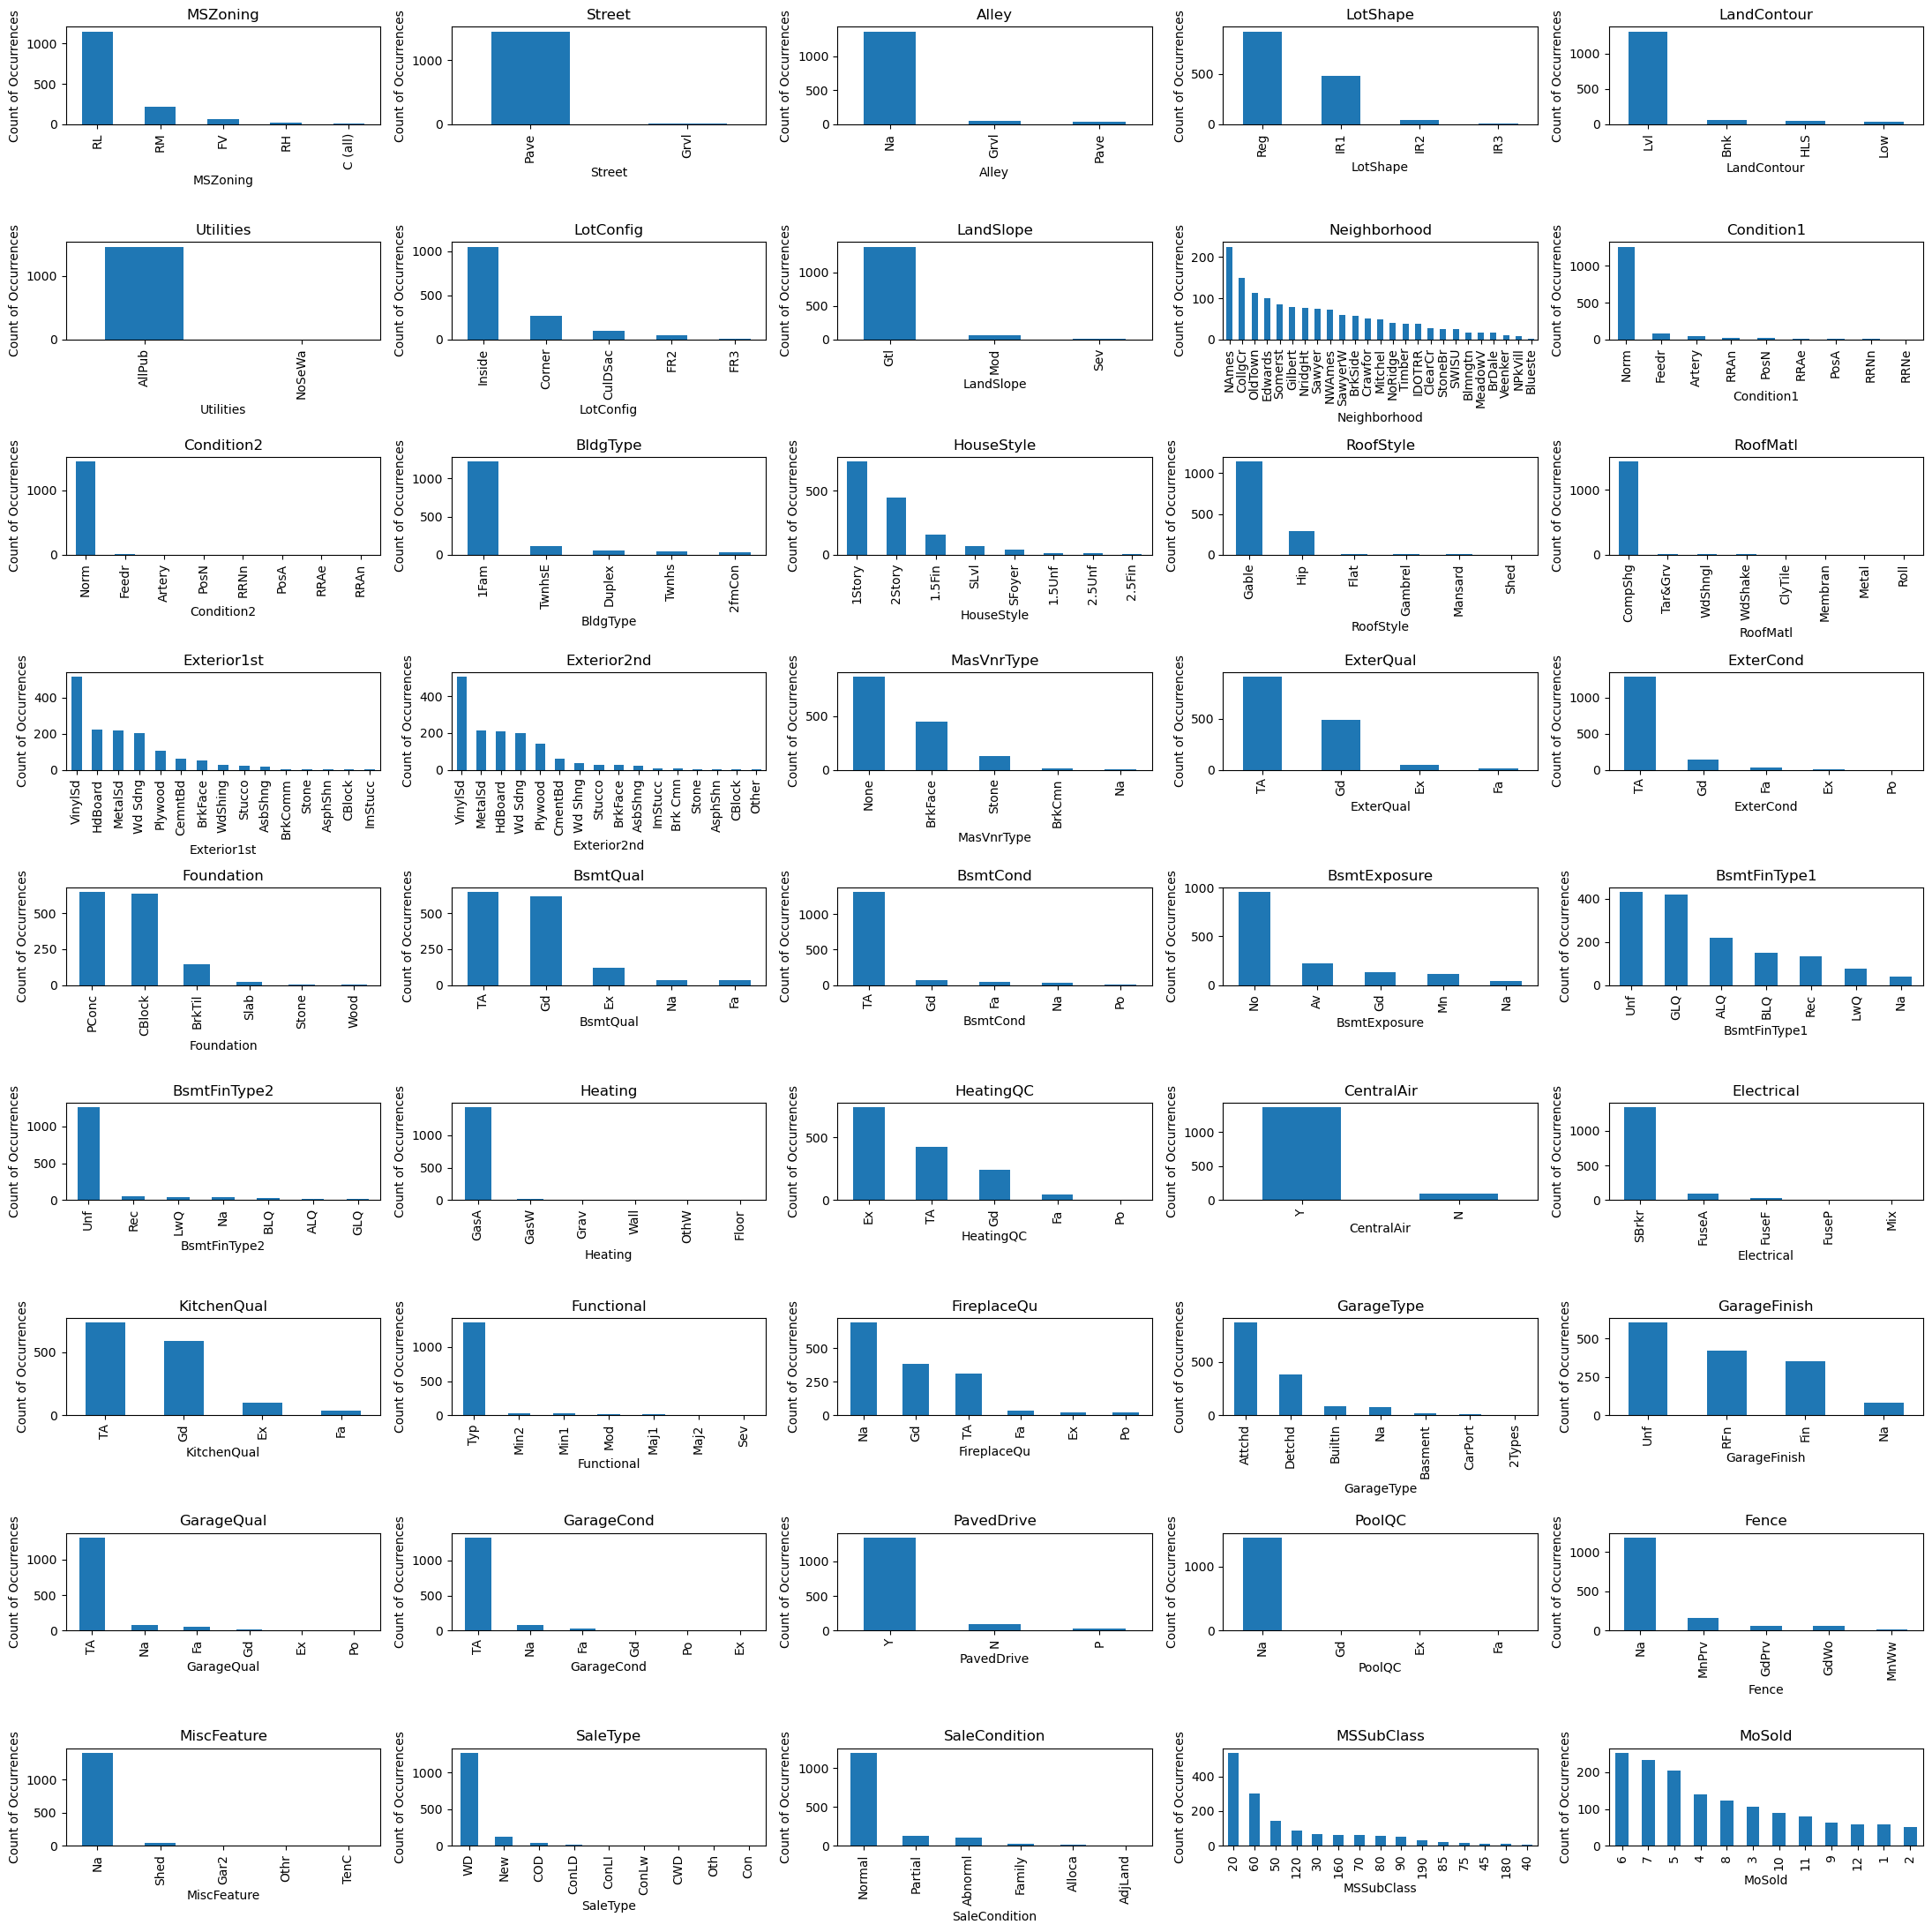

In [73]:

plt.figure(figsize = (22,22))
for i,col in enumerate(categorical_features.columns[:]):
    plt.subplot(9,5,i+1)
    count = categorical_features.groupby(col).size()

    # Sort the count of occurrences in descending order
    count = count.sort_values(ascending=False)

    # Plot the count of occurrences for each group
    count.plot.bar()

    # Add a title and labels to the x and y axes
    plt.title("{}".format(col))
    plt.xlabel(col)
    plt.ylabel("Count of Occurrences")

    # Show the plot

plt.tight_layout()

## Checking Categorical feature's importance

In [39]:
y= train.SalePrice.values

# Train a random forest classifier on the iris data
clf = RandomForestClassifier()
clf.fit(categorical_features, y)

# Calculate the feature importances
importances = clf.feature_importances_

# Print the feature importances
for feature, importance in zip(categorical_features.columns, importances):
    print(f"Feature: {feature}, Importance: {importance}")


ValueError: could not convert string to float: 'RL'